# Machine Learning with PyTorch and Scikit-Learn  
# -- Code Examples

## Package version checks

Add folder to path in order to load from the check_packages.py script:

In [2]:
import sys
sys.path.insert(0, '..')

Check recommended package versions:

In [3]:
from python_environment_check import check_packages


d = {
    'torch': '1.9.0',
}
check_packages(d)

[OK] Your Python version is 3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:35:11) 
[Clang 11.1.0 ]
[OK] torch 1.10.0


# Transformers – Improving Natural Language Processing with Attention Mechanisms (Part 1/3)

**Outline**

- [Adding an attention mechanism to RNNs](#Adding-an-attention-mechanism-to-RNNs)
  - [Attention helps RNNs with accessing information](#Attention-helps-RNNs-with-accessing-information)
  - [The original attention mechanism for RNNs](#The-original-attention-mechanism-for-RNNs)
  - [Processing the inputs using a bidirectional RNN](#Processing-the-inputs-using-a-bidirectional-RNN)
  - [Generating outputs from context vectors](#Generating-outputs-from-context-vectors)
  - [Computing the attention weights](#Computing-the-attention-weights)
- [Introducing the self-attention mechanism](#Introducing-the-self-attention-mechanism)
  - [Starting with a basic form of self-attention](#Starting-with-a-basic-form-of-self-attention)
  - [Parameterizing the self-attention mechanism: scaled dot-product attention](#Parameterizing-the-self-attention-mechanism-scaled-dot-product-attention)
- [Attention is all we need: introducing the original transformer architecture](#Attention-is-all-we-need-introducing-the-original-transformer-architecture)
  - [Encoding context embeddings via multi-head attention](#Encoding-context-embeddings-via-multi-head-attention)
  - [Learning a language model: decoder and masked multi-head attention](#Learning-a-language-model-decoder-and-masked-multi-head-attention)
  - [Implementation details: positional encodings and layer normalization](#Implementation-details-positional-encodings-and-layer-normalization)

In [2]:
from IPython.display import Image

## Adding an attention mechanism to RNNs

### Attention helps RNNs with accessing information

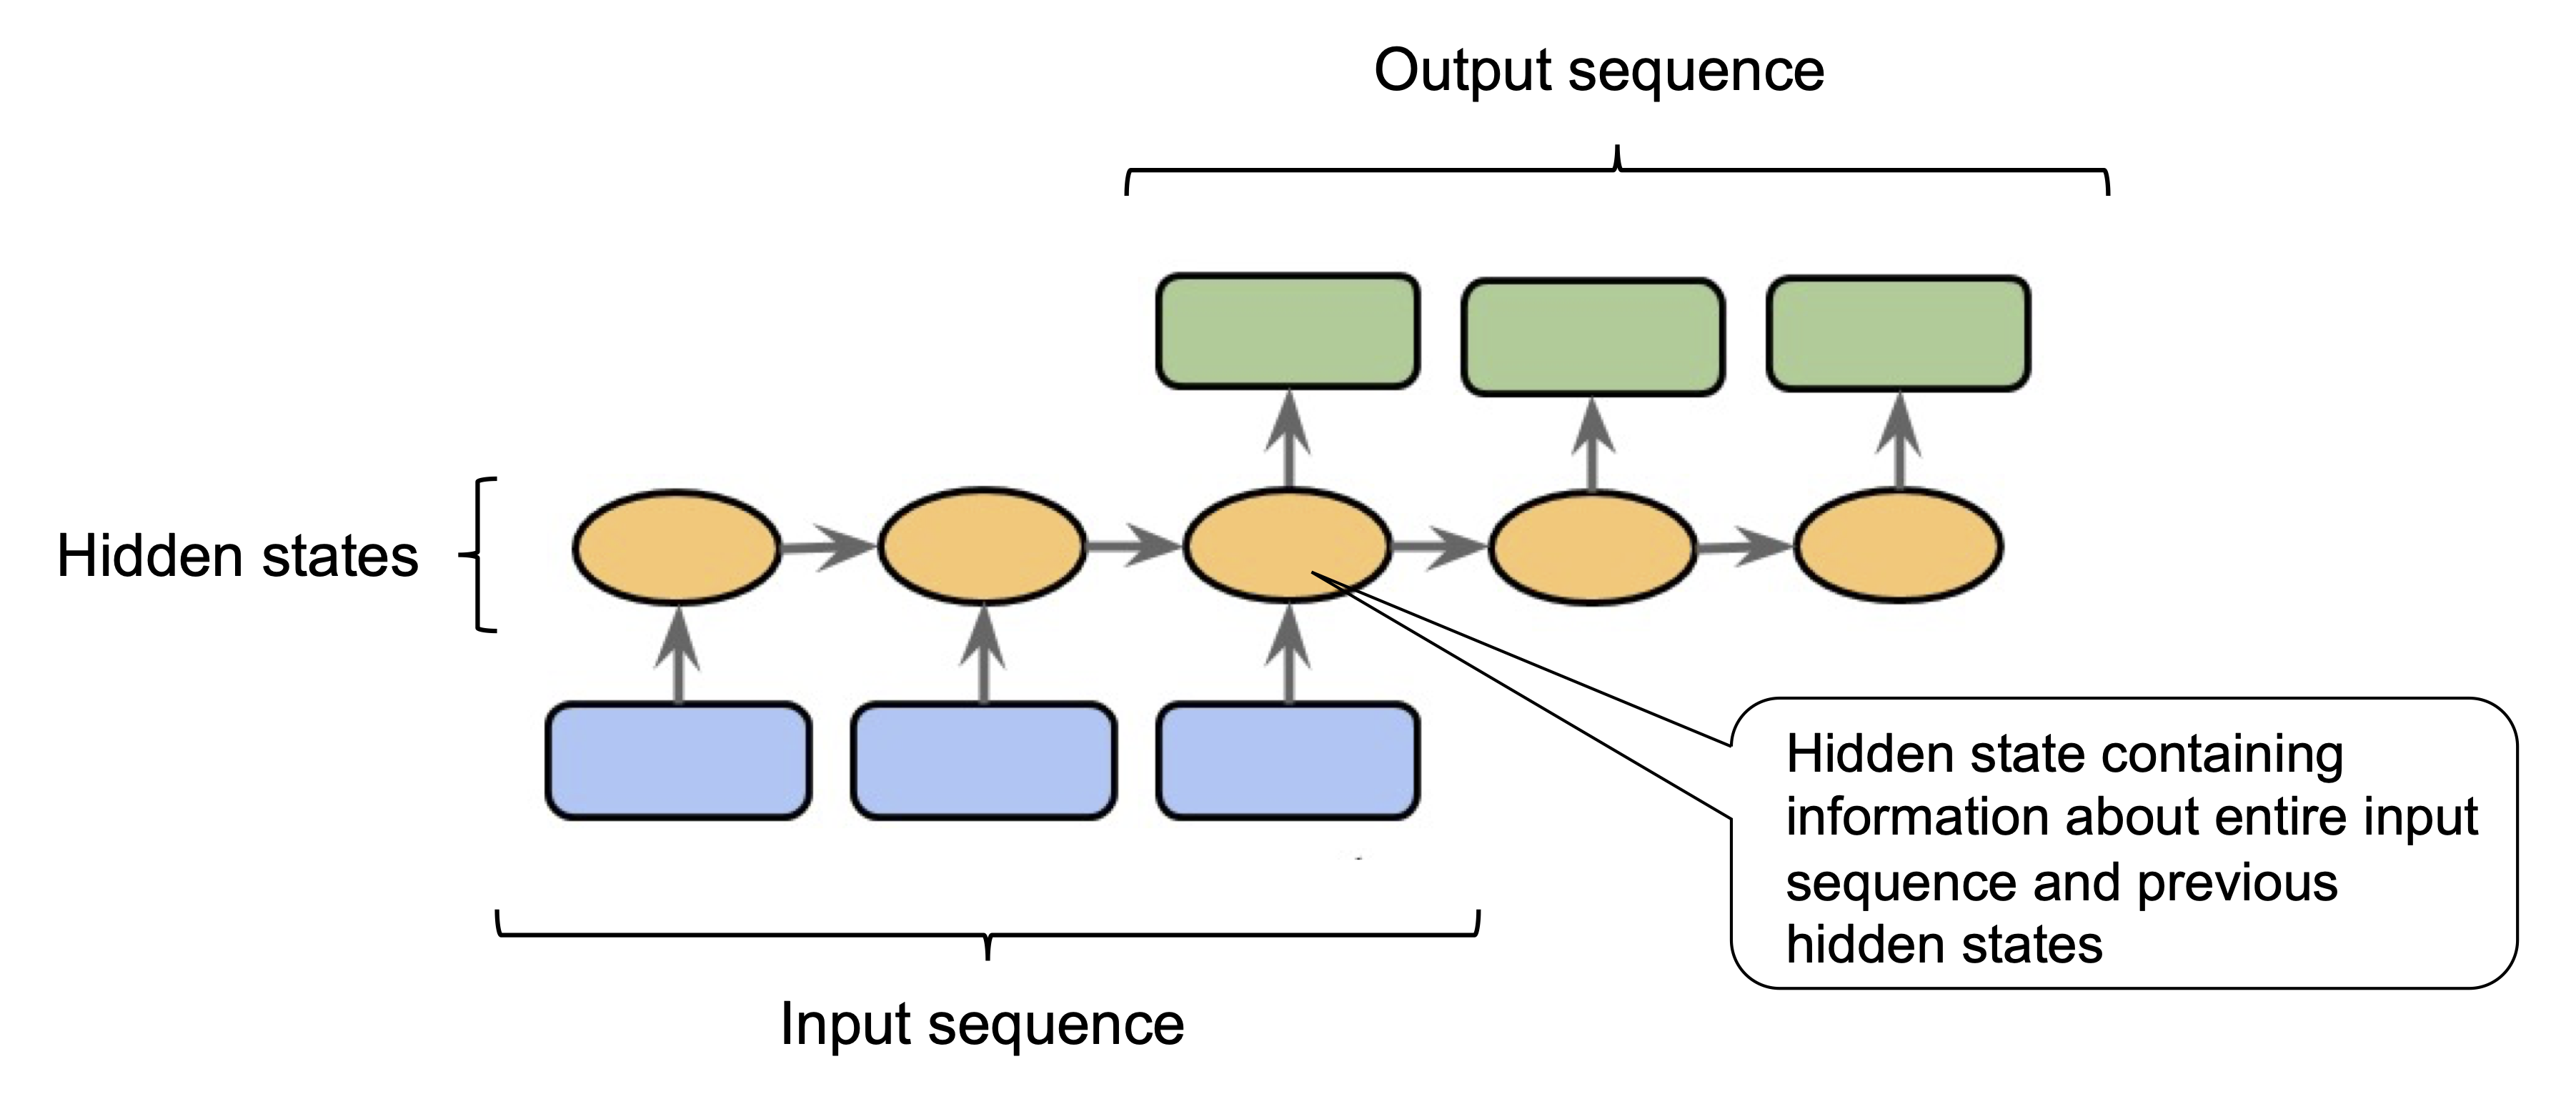

In [3]:
Image(filename='figures/16_01.png', width=500)

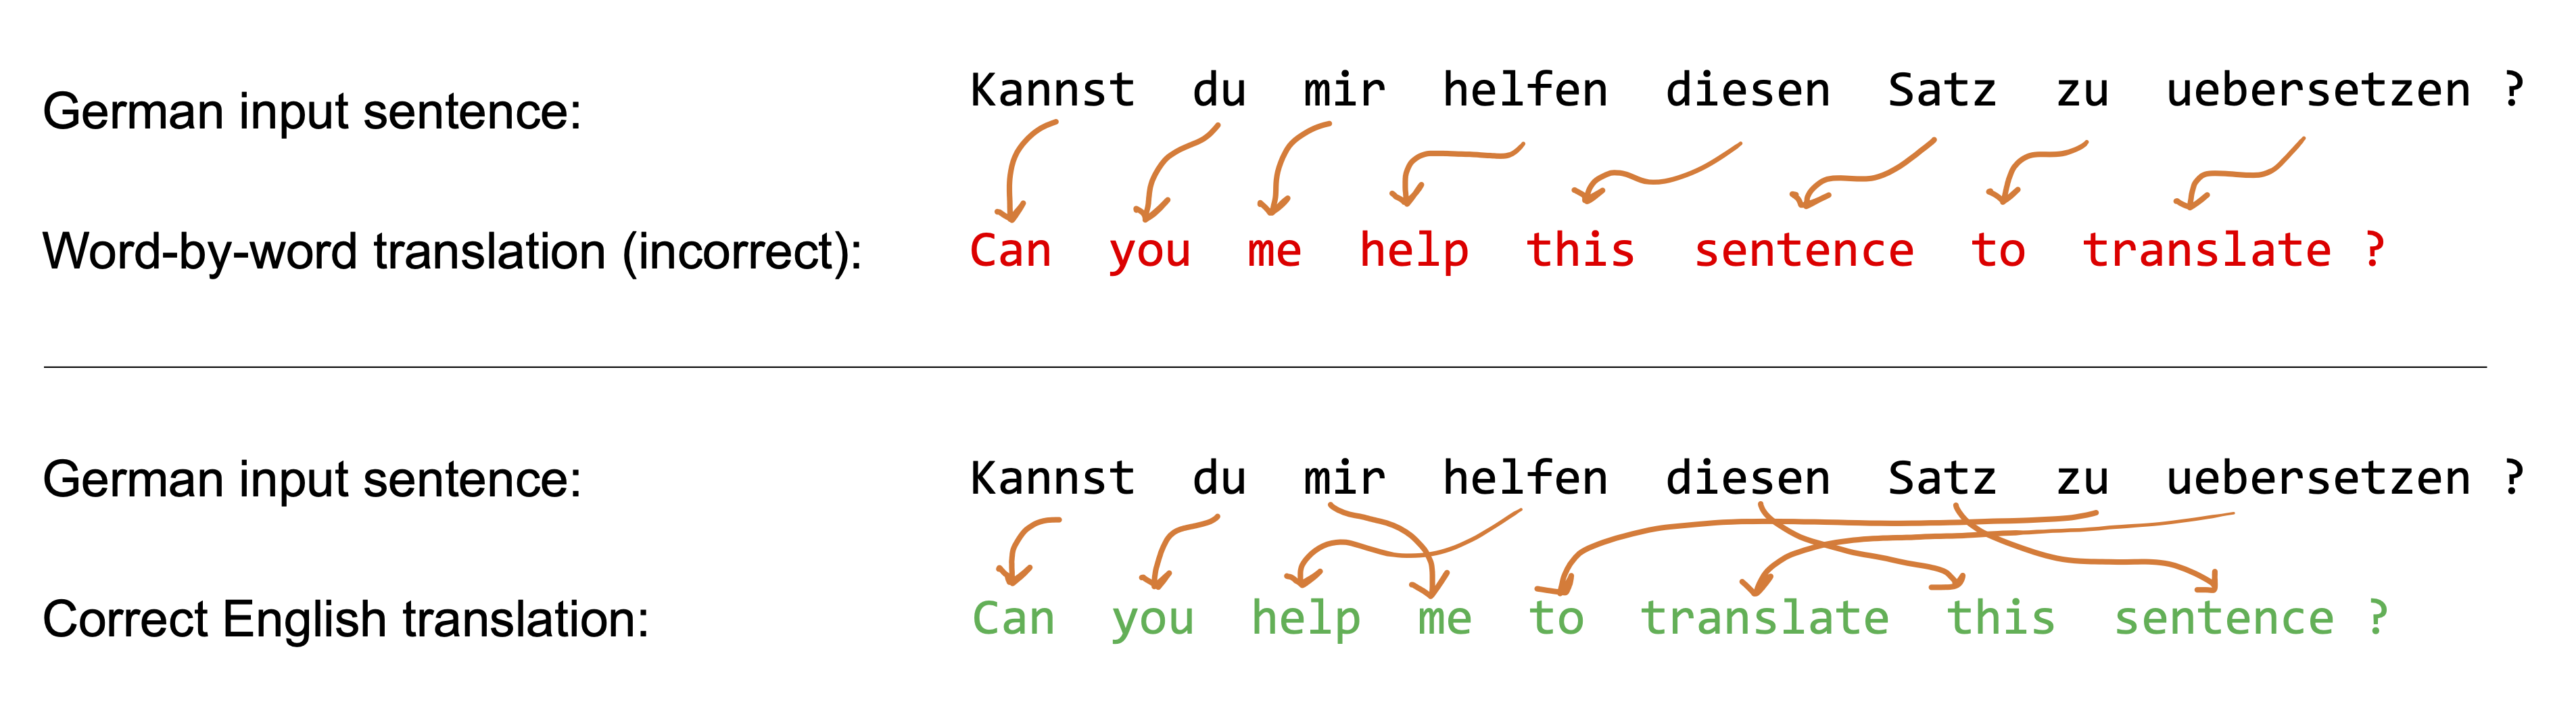

In [4]:
Image(filename='figures/16_02.png', width=700)

### The original attention mechanism for RNNs

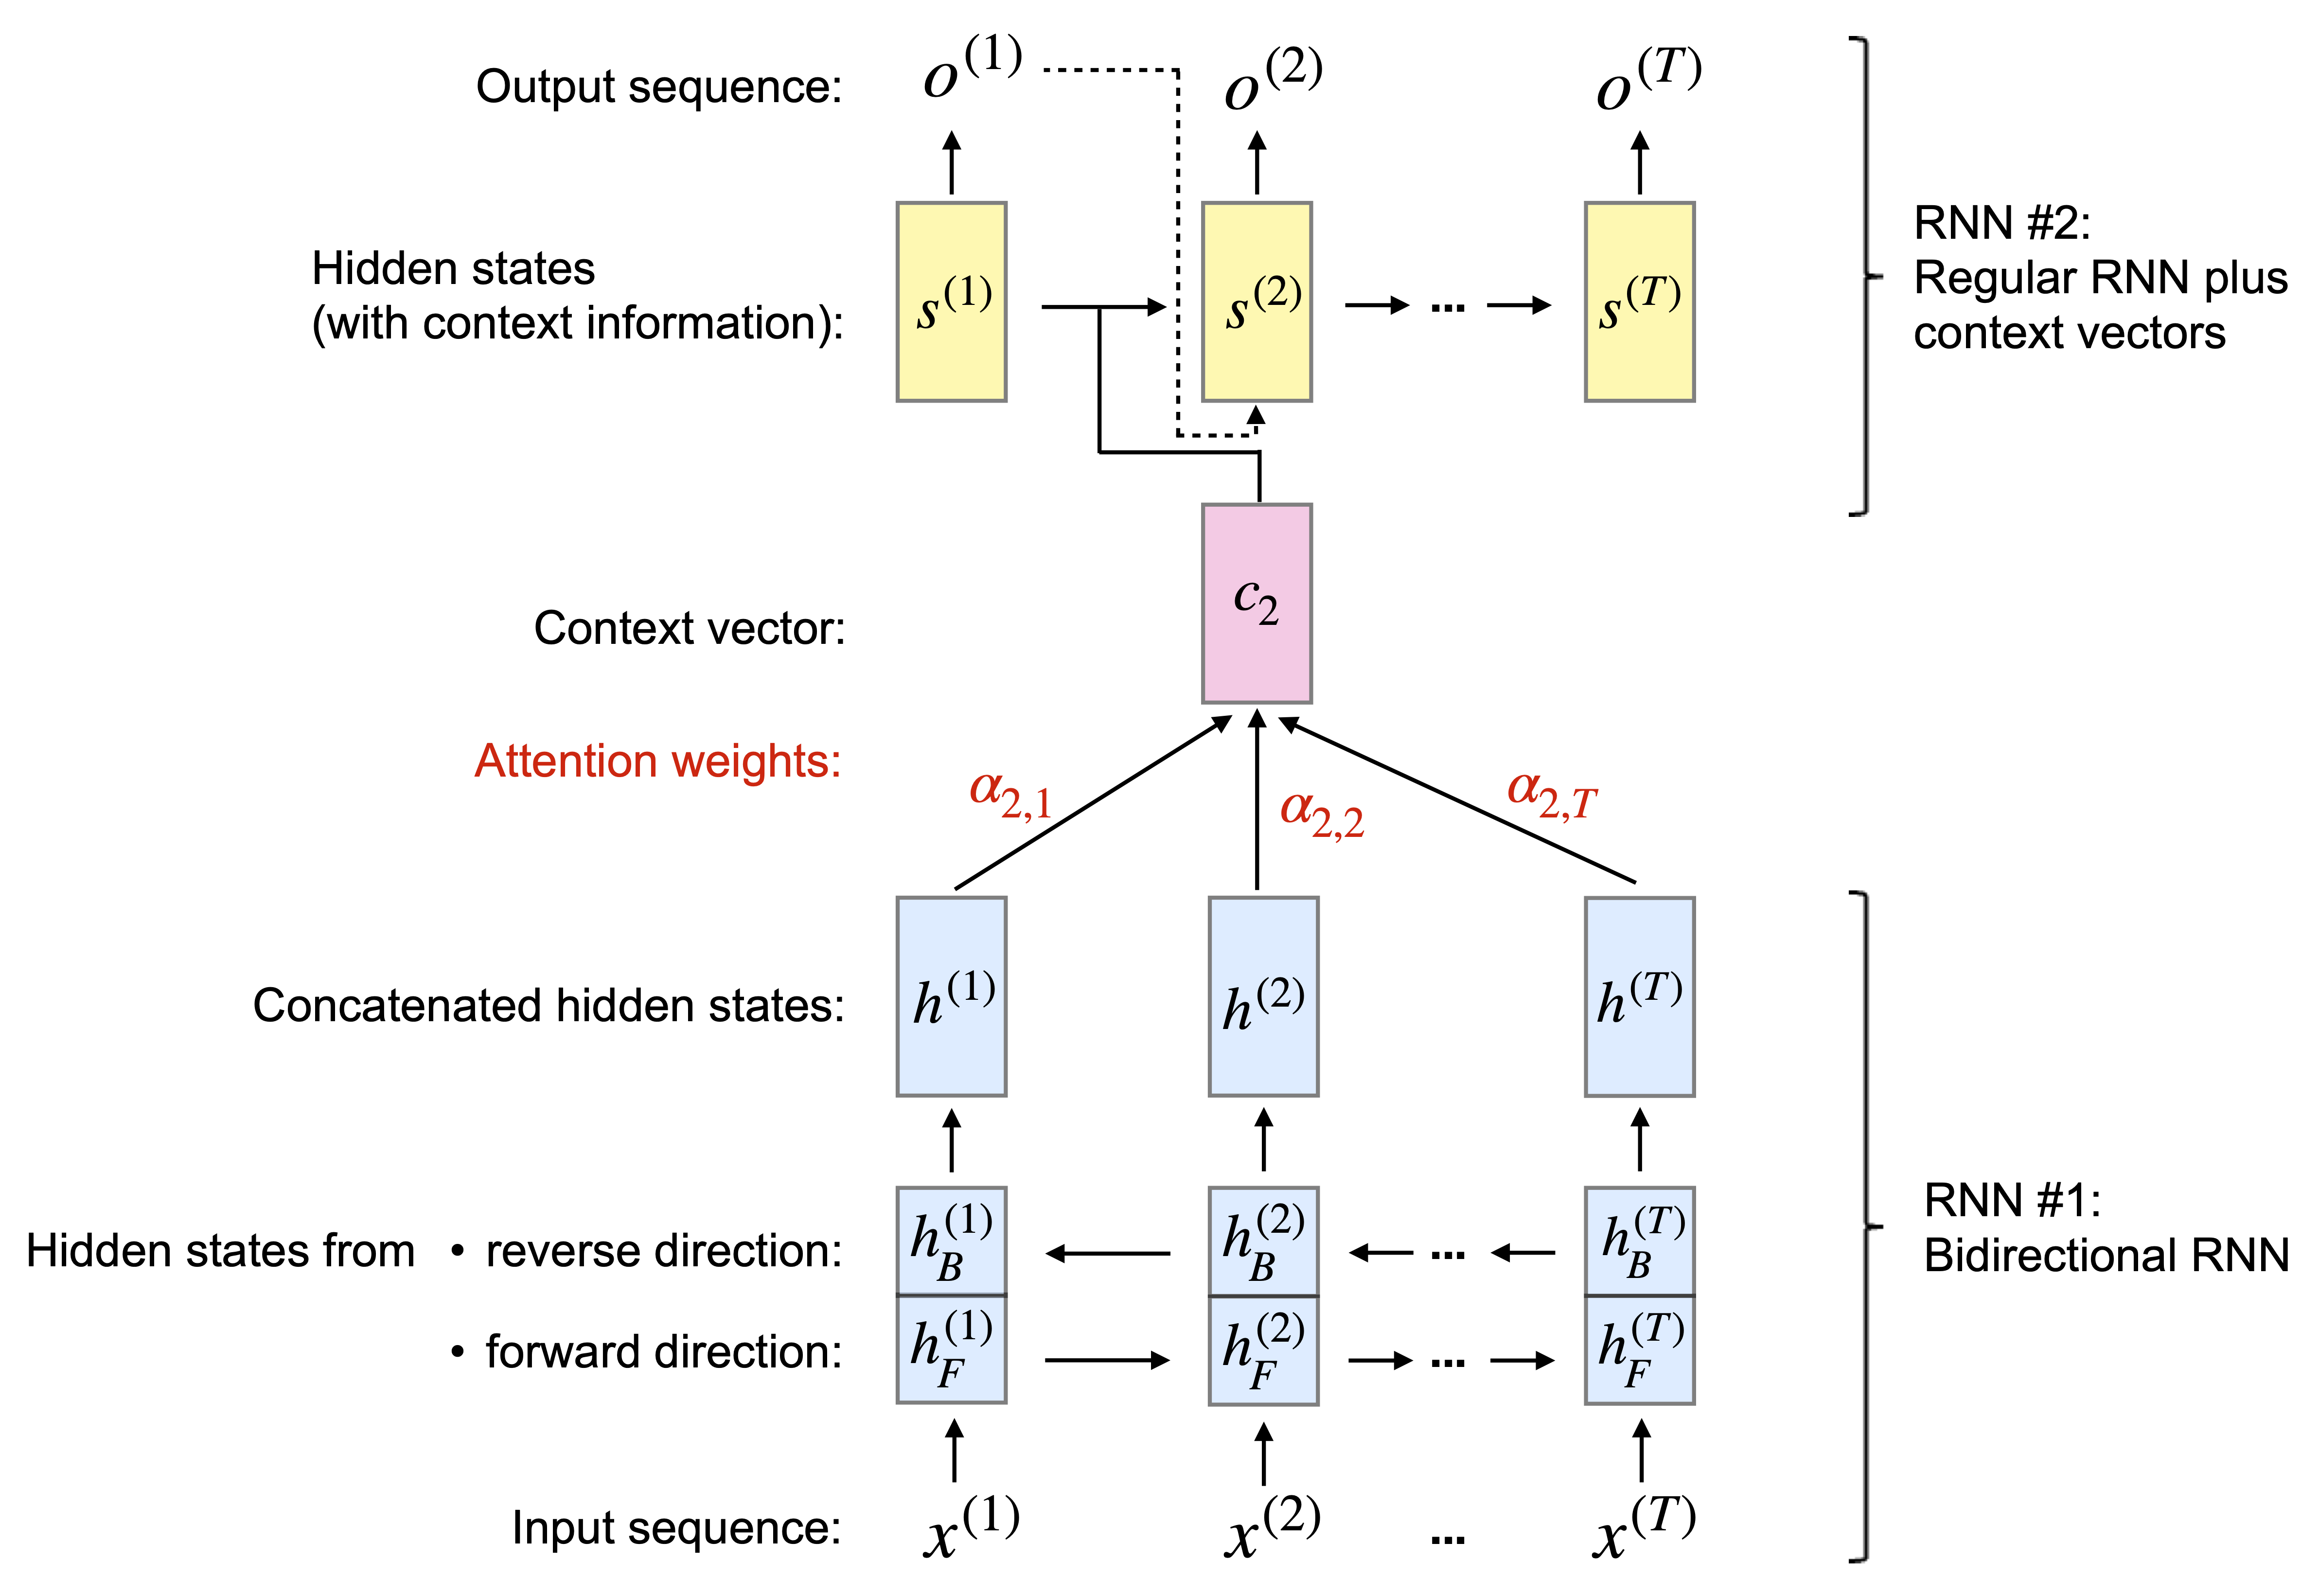

In [5]:
Image(filename='figures/16_03.png', width=600)

### Processing the inputs using a bidirectional RNN
### Generating outputs from context vectors
### Computing the attention weights

## Introducing the self-attention mechanism

### Starting with a basic form of self-attention

- Assume we have an input sentence that we encoded via a dictionary, which maps the words to integers as discussed in the RNN chapter:

In [6]:
import torch


# input sequence / sentence:
#  "Can you help me to translate this sentence"

sentence = torch.tensor(
    [0, # can
     7, # you     
     1, # help
     2, # me
     5, # to
     6, # translate
     4, # this
     3] # sentence
)

sentence

tensor([0, 7, 1, 2, 5, 6, 4, 3])

- Next, assume we have an embedding of the words, i.e., the words are represented as real vectors.
- Since we have 8 words, there will be 8 vectors. Each vector is 16-dimensional:

In [7]:
torch.manual_seed(123)
embed = torch.nn.Embedding(10, 16)
embedded_sentence = embed(sentence).detach()
embedded_sentence.shape

torch.Size([8, 16])

- The goal is to compute the context vectors $\boldsymbol{z}^{(i)}=\sum_{j=1}^{T} \alpha_{i j} \boldsymbol{x}^{(j)}$, which involve attention weights $\alpha_{i j}$.
- In turn, the attention weights $\alpha_{i j}$ involve the $\omega_{i j}$ values
- Let's start with the $\omega_{i j}$'s first, which are computed as dot-products:

$$\omega_{i j}=\boldsymbol{x}^{(i)^{\top}} \boldsymbol{x}^{(j)}$$



In [8]:
omega = torch.empty(8, 8)

for i, x_i in enumerate(embedded_sentence):
    for j, x_j in enumerate(embedded_sentence):
        omega[i, j] = torch.dot(x_i, x_j)

- Actually, let's compute this more efficiently by replacing the nested for-loops with a matrix multiplication:

In [9]:
omega_mat = embedded_sentence.matmul(embedded_sentence.T)

In [10]:
torch.allclose(omega_mat, omega)

True

- Next, let's compute the attention weights by normalizing the "omega" values so they sum to 1

$$\alpha_{i j}=\frac{\exp \left(\omega_{i j}\right)}{\sum_{j=1}^{T} \exp \left(\omega_{i j}\right)}=\operatorname{softmax}\left(\left[\omega_{i j}\right]_{j=1 \ldots T}\right)$$

$$\sum_{j=1}^{T} \alpha_{i j}=1$$

In [11]:
import torch.nn.functional as F

attention_weights = F.softmax(omega, dim=1)
attention_weights.shape

torch.Size([8, 8])

- We can conform that the columns sum up to one:

In [12]:
attention_weights.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

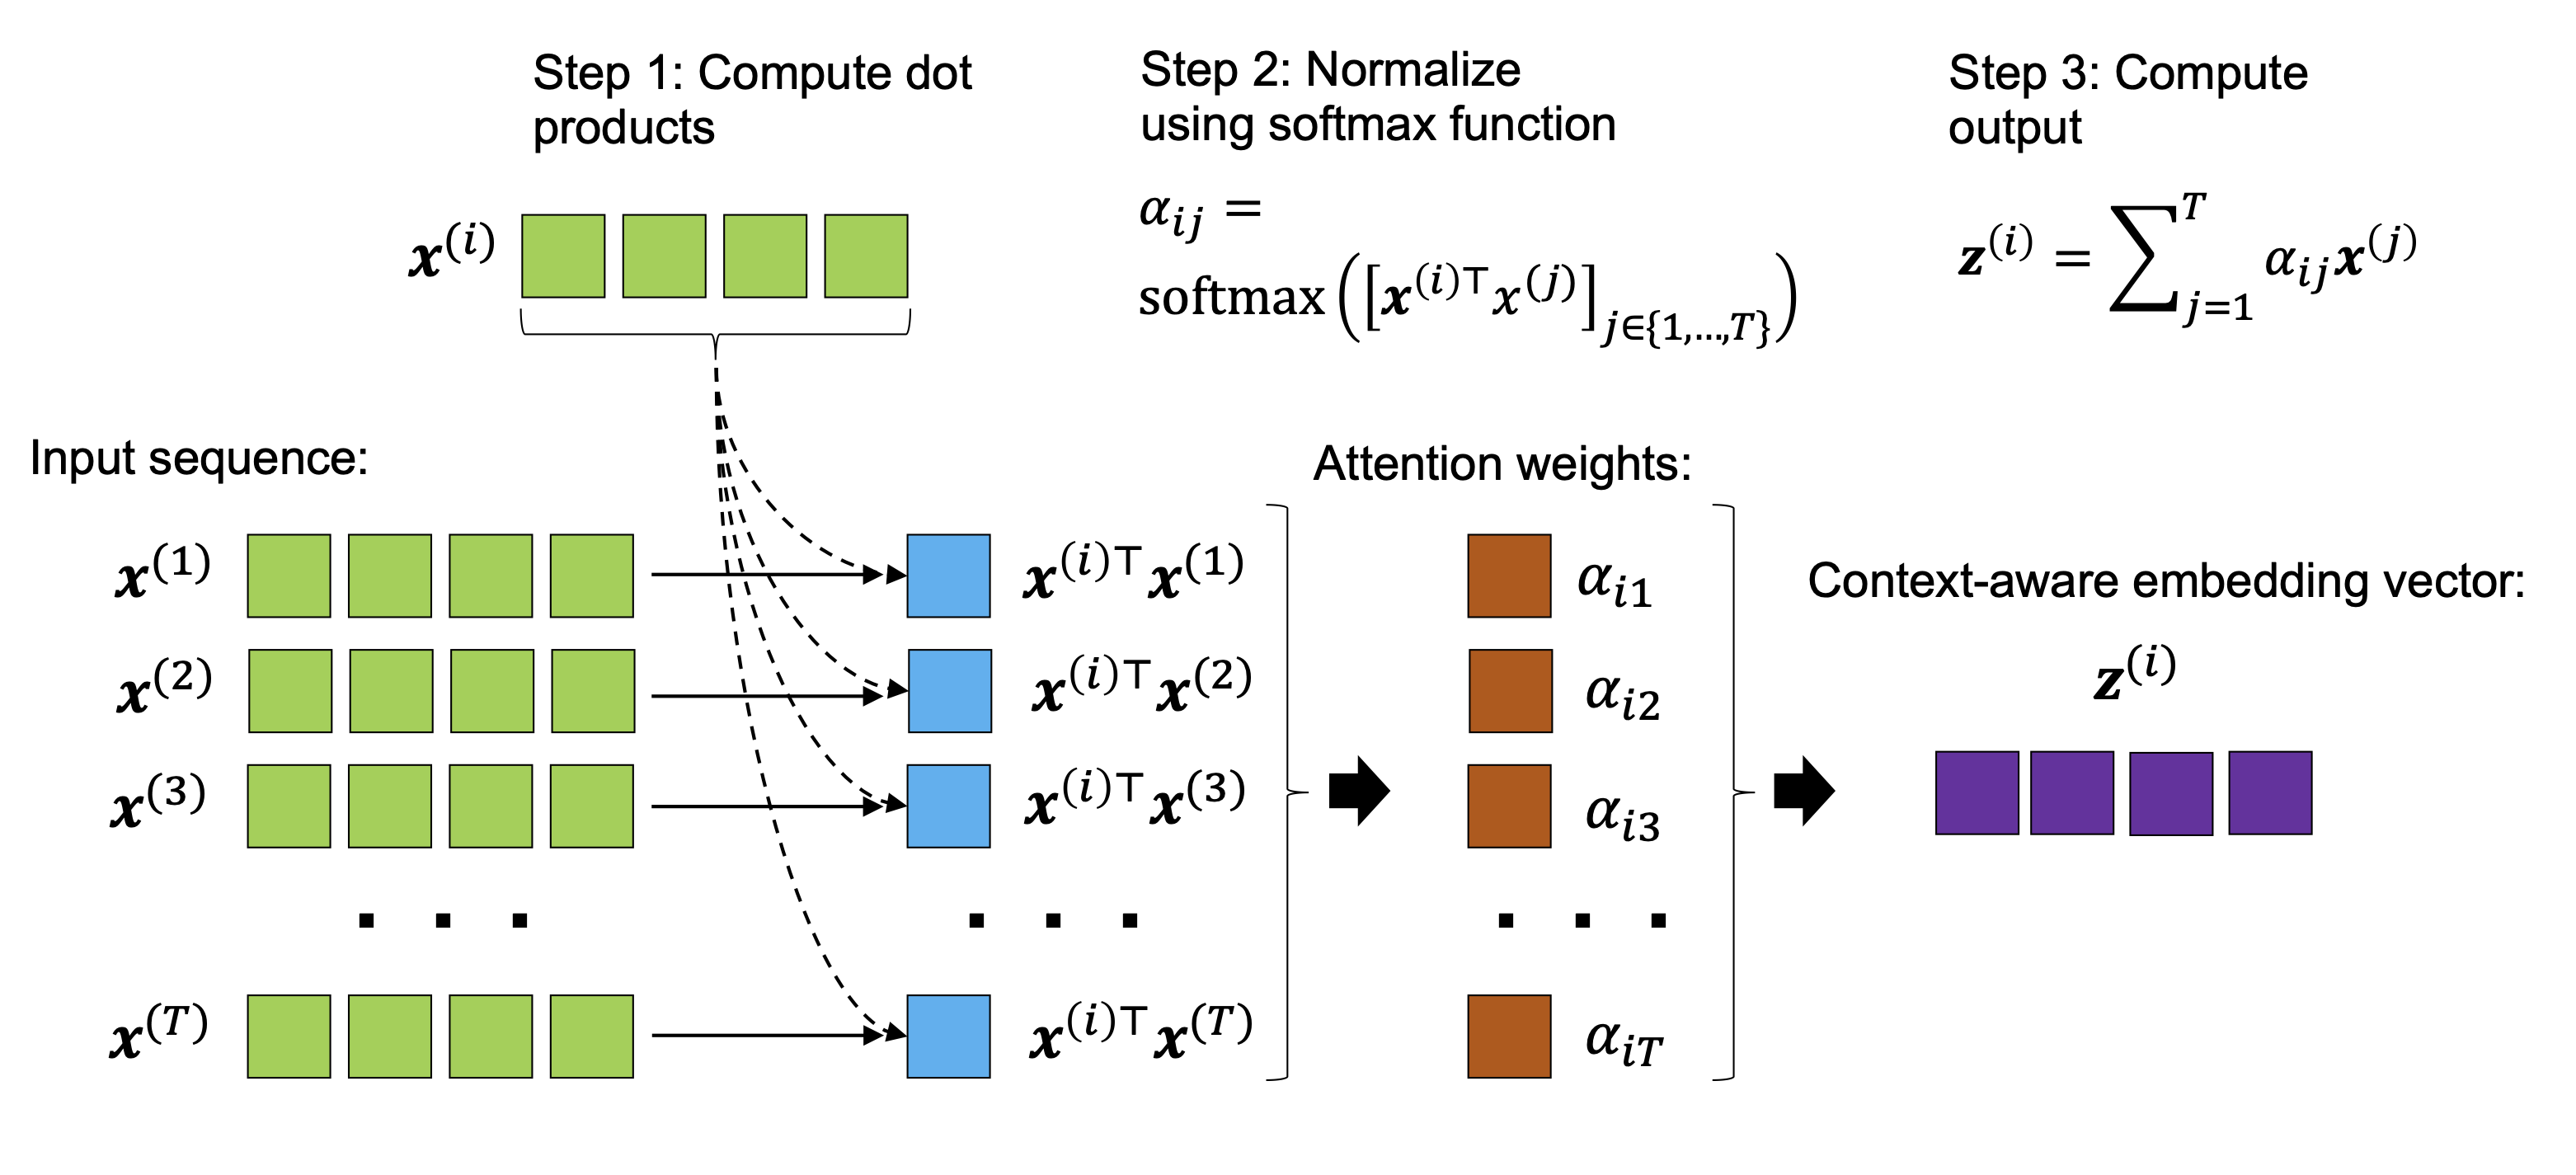

In [13]:
Image(filename='figures/16_04.png', width=700)

- Now that we have the attention weights, we can compute the context vectors $\boldsymbol{z}^{(i)}=\sum_{j=1}^{T} \alpha_{i j} \boldsymbol{x}^{(j)}$, which involve attention weights $\alpha_{i j}$
- For instance, to compute the context-vector of the 2nd input element (the element at index 1), we can perform the following computation:

In [14]:
x_2 = embedded_sentence[1, :]
context_vec_2 = torch.zeros(x_2.shape)
for j in range(8):
    x_j = embedded_sentence[j, :]
    context_vec_2 += attention_weights[1, j] * x_j
    
context_vec_2

tensor([-9.3975e-01, -4.6856e-01,  1.0311e+00, -2.8192e-01,  4.9373e-01,
        -1.2896e-02, -2.7327e-01, -7.6358e-01,  1.3958e+00, -9.9543e-01,
        -7.1288e-04,  1.2449e+00, -7.8077e-02,  1.2765e+00, -1.4589e+00,
        -2.1601e+00])

- Or, more effiently, using linear algebra and matrix multiplication:

In [15]:
context_vectors = torch.matmul(
        attention_weights, embedded_sentence)


torch.allclose(context_vec_2, context_vectors[1])

True

###  Parameterizing the self-attention mechanism: scaled dot-product attention

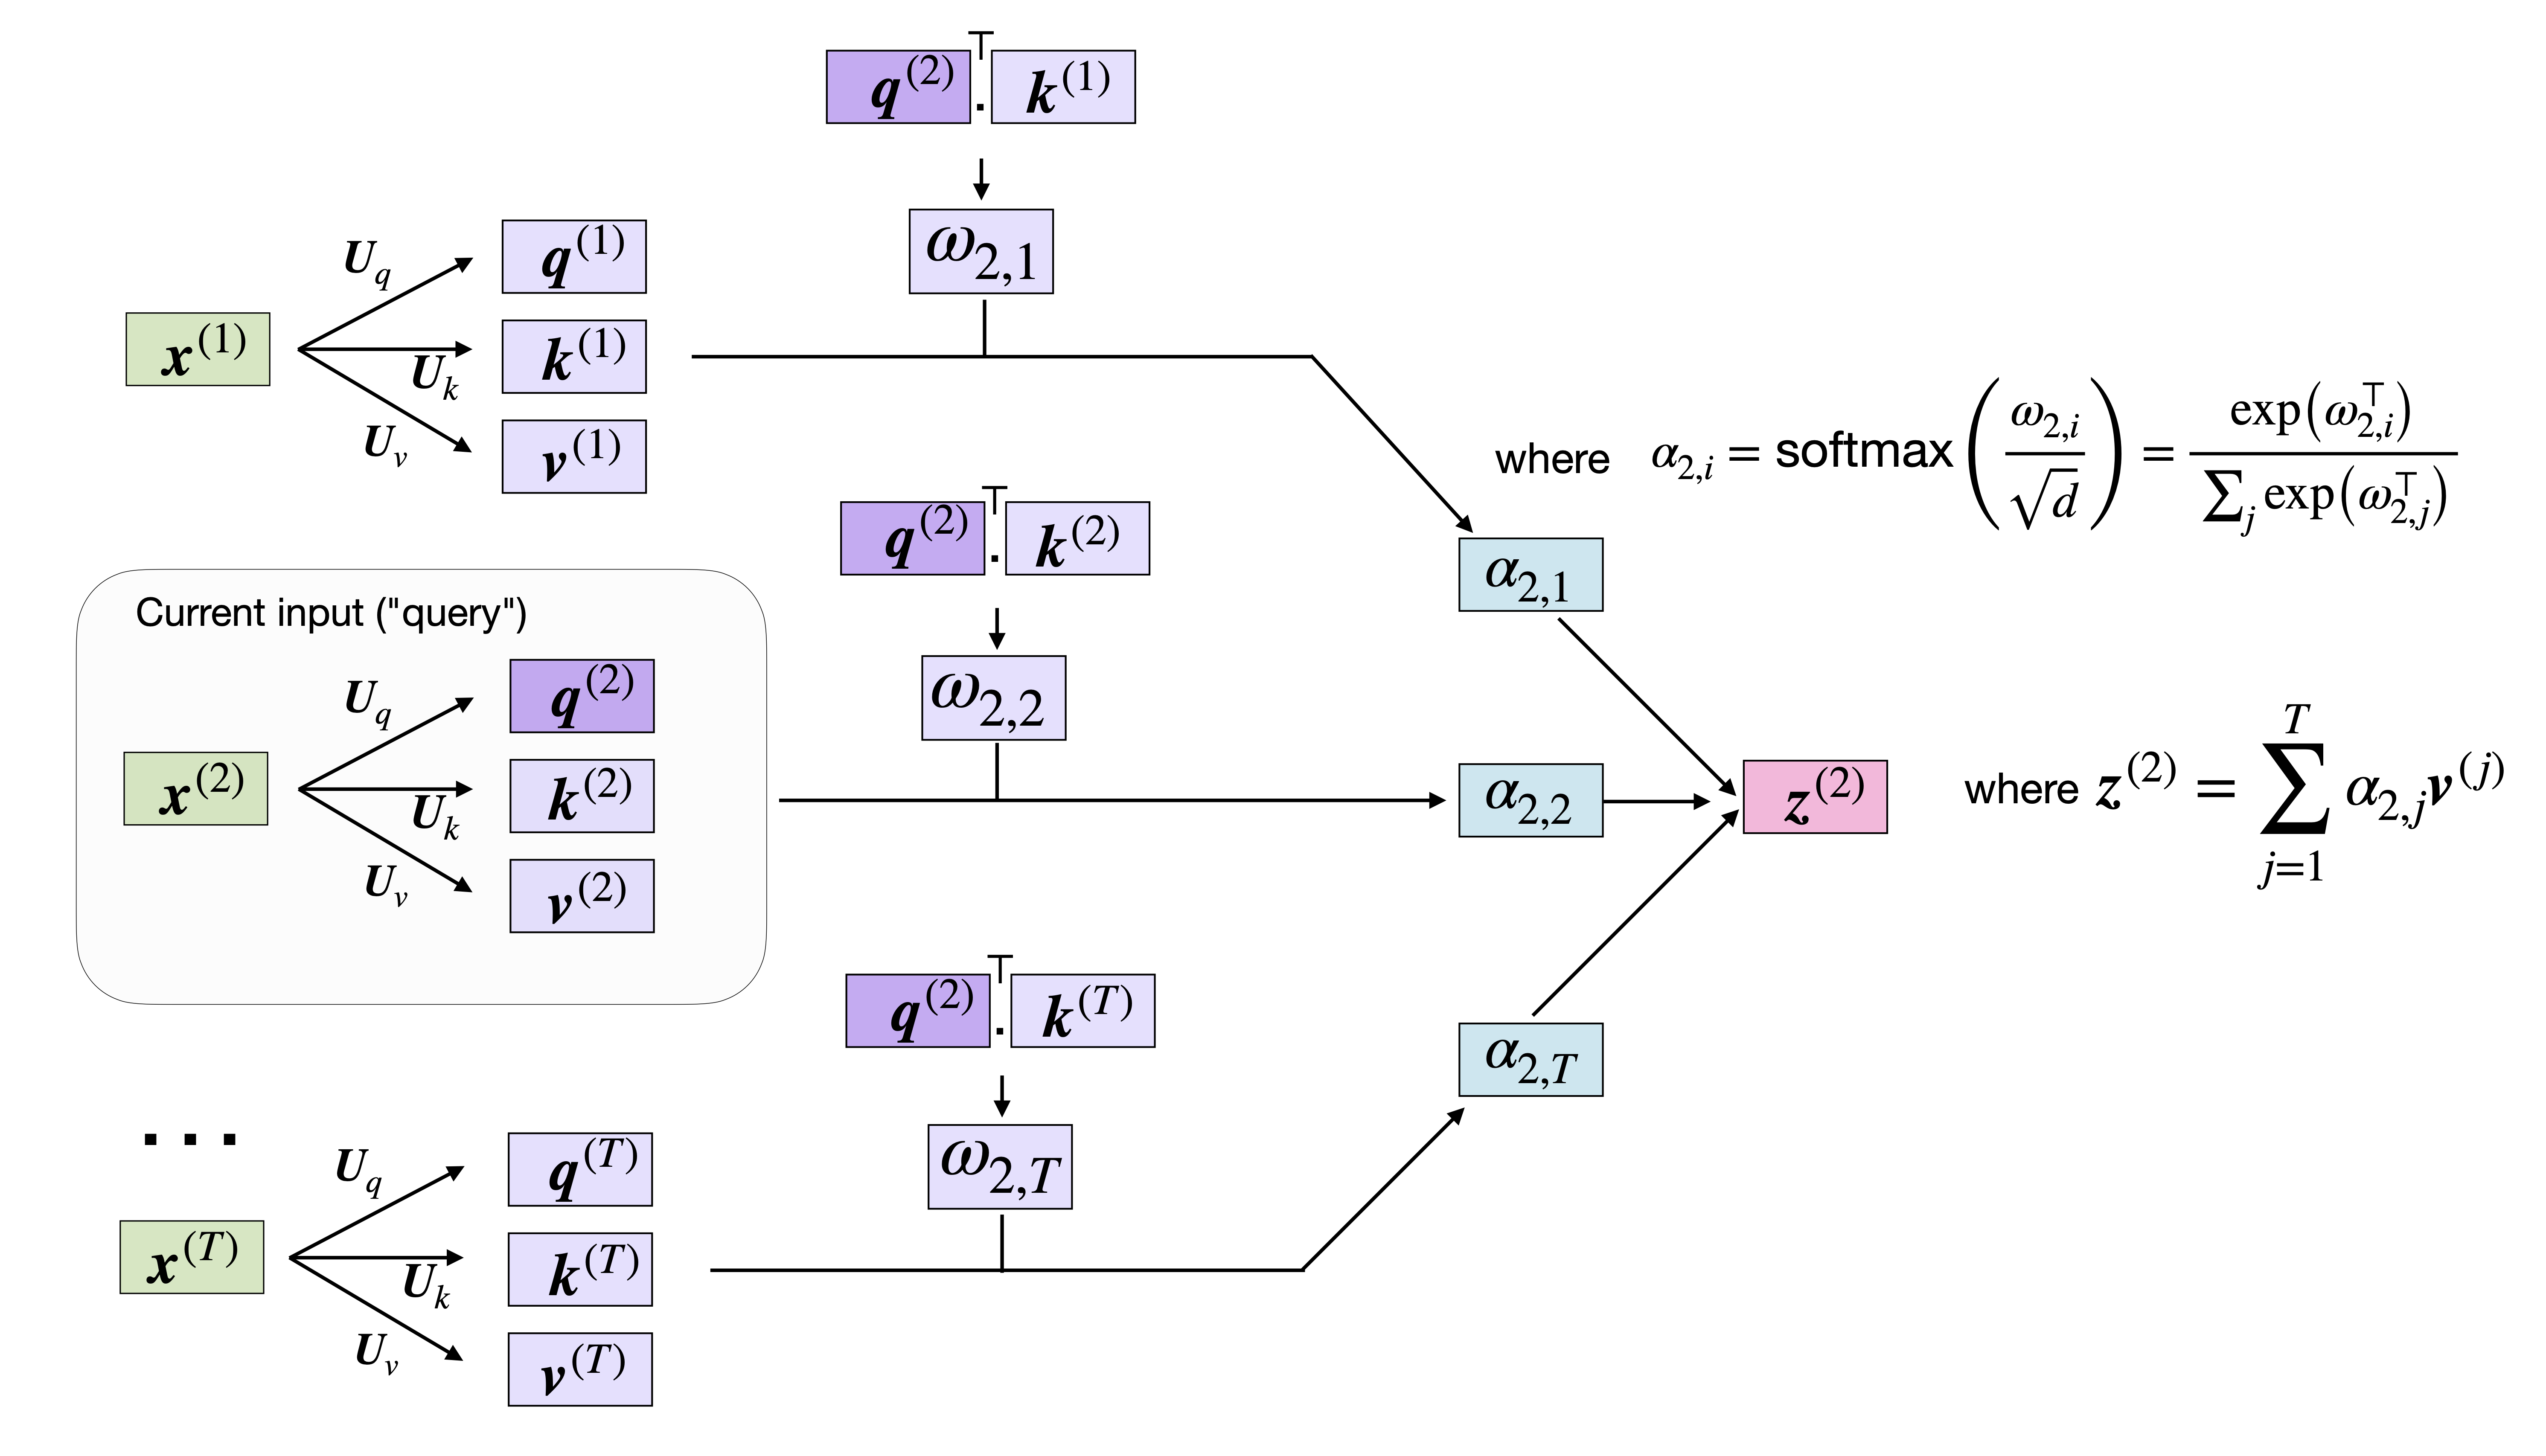

In [16]:
Image(filename='figures/16_05.png', width=700)

In [17]:
torch.manual_seed(123)

d = embedded_sentence.shape[1]
U_query = torch.rand(d, d)
U_key = torch.rand(d, d)
U_value = torch.rand(d, d)

In [18]:
x_2 = embedded_sentence[1]
query_2 = U_query.matmul(x_2)

In [19]:
key_2 = U_key.matmul(x_2)
value_2 = U_value.matmul(x_2)

In [20]:
keys = U_key.matmul(embedded_sentence.T).T
torch.allclose(key_2, keys[1])

True

In [21]:
values = U_value.matmul(embedded_sentence.T).T
torch.allclose(value_2, values[1])

True

In [22]:
omega_23 = query_2.dot(keys[2])
omega_23

tensor(14.3667)

In [23]:
omega_2 = query_2.matmul(keys.T)
omega_2

tensor([-25.1623,   9.3602,  14.3667,  32.1482,  53.8976,  46.6626,  -1.2131,
        -32.9391])

In [24]:
attention_weights_2 = F.softmax(omega_2 / d**0.5, dim=0)
attention_weights_2

tensor([2.2317e-09, 1.2499e-05, 4.3696e-05, 3.7242e-03, 8.5596e-01, 1.4025e-01,
        8.8896e-07, 3.1936e-10])

In [25]:
#context_vector_2nd = torch.zeros(values[1, :].shape)
#for j in range(8):
#    context_vector_2nd += attention_weights_2[j] * values[j, :]
    
#context_vector_2nd

In [26]:
context_vector_2 = attention_weights_2.matmul(values)
context_vector_2

tensor([-1.2226, -3.4387, -4.3928, -5.2125, -1.1249, -3.3041, -1.4316, -3.2765,
        -2.5114, -2.6105, -1.5793, -2.8433, -2.4142, -0.3998, -1.9917, -3.3499])

## Attention is all we need: introducing the original transformer architecture

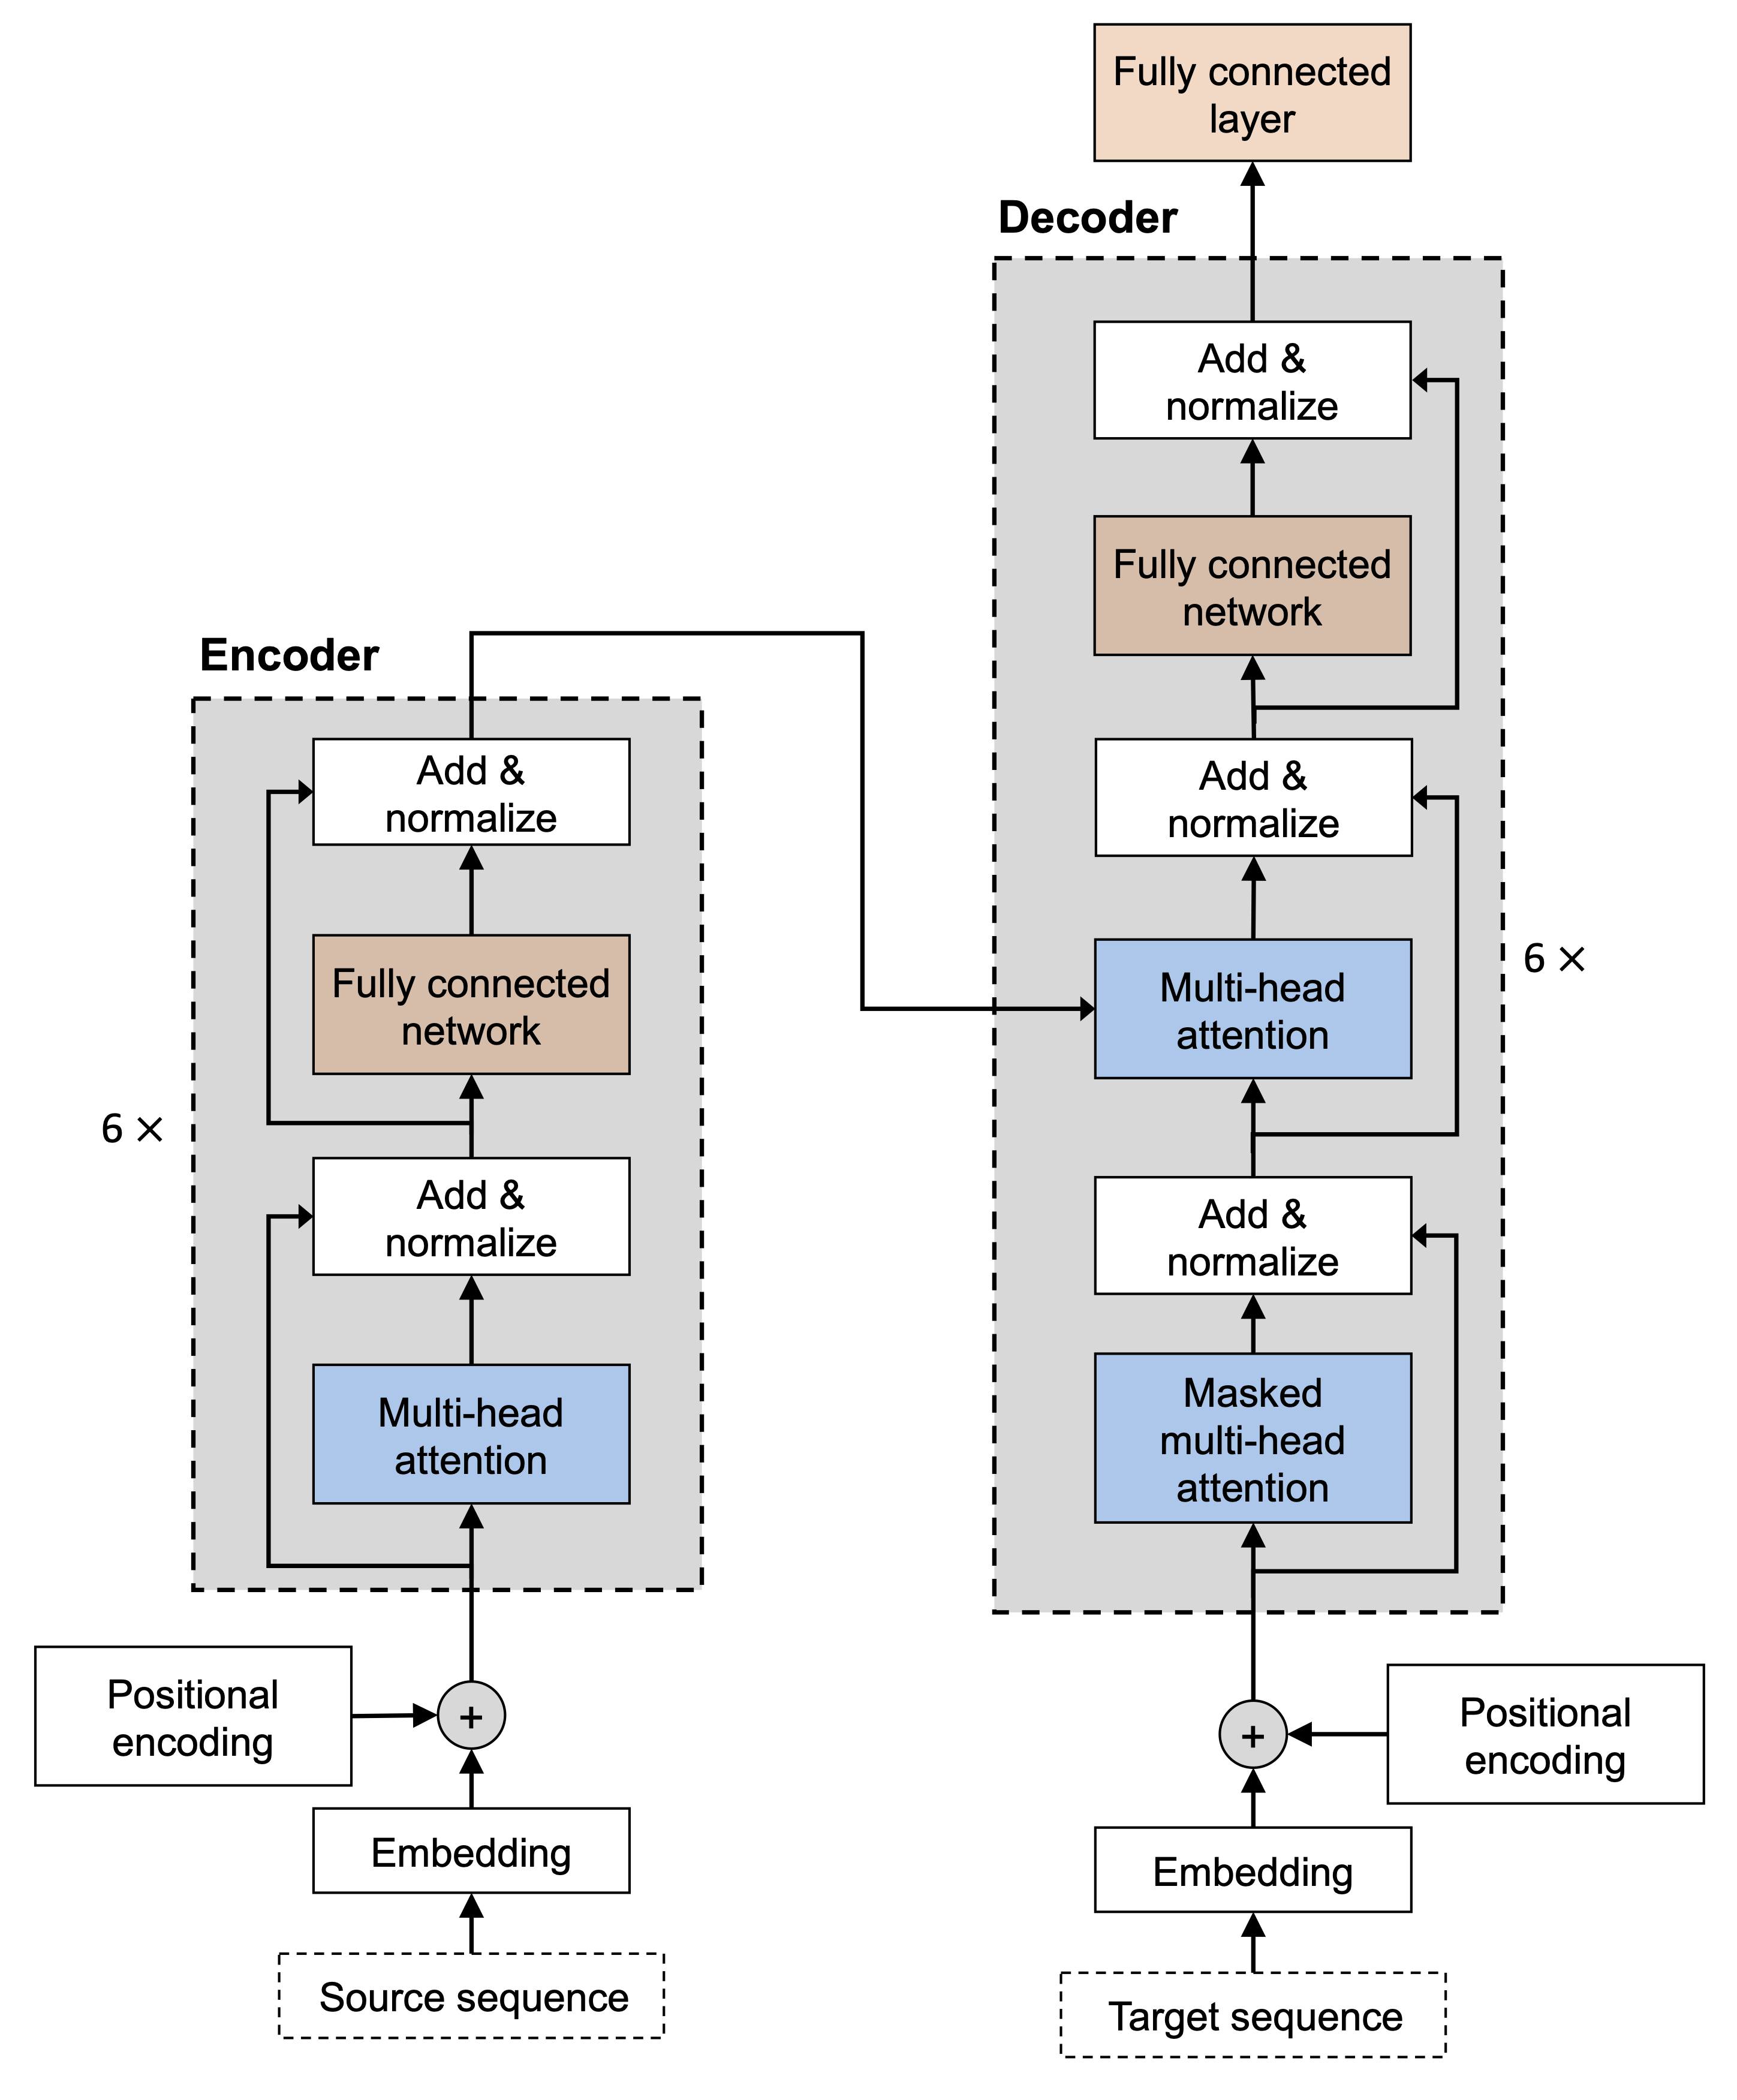

In [27]:
Image(filename='figures/16_06.png', width=600)

###  Encoding context embeddings via multi-head attention 

In [28]:
torch.manual_seed(123)

d = embedded_sentence.shape[1]
one_U_query = torch.rand(d, d)

In [29]:
h = 8
multihead_U_query = torch.rand(h, d, d)
multihead_U_key = torch.rand(h, d, d)
multihead_U_value = torch.rand(h, d, d)

In [30]:
multihead_query_2 = multihead_U_query.matmul(x_2)
multihead_query_2.shape

torch.Size([8, 16])

In [31]:
multihead_key_2 = multihead_U_key.matmul(x_2)
multihead_value_2 = multihead_U_value.matmul(x_2)

In [32]:
multihead_key_2[2]

tensor([-1.9619, -0.7701, -0.7280, -1.6840, -1.0801, -1.6778,  0.6763,  0.6547,
         1.4445, -2.7016, -1.1364, -1.1204, -2.4430, -0.5982, -0.8292, -1.4401])

In [33]:
stacked_inputs = embedded_sentence.T.repeat(8, 1, 1)
stacked_inputs.shape

torch.Size([8, 16, 8])

In [34]:
multihead_keys = torch.bmm(multihead_U_key, stacked_inputs)
multihead_keys.shape

torch.Size([8, 16, 8])

In [35]:
multihead_keys = multihead_keys.permute(0, 2, 1)
multihead_keys.shape

torch.Size([8, 8, 16])

In [36]:
multihead_keys[2, 1] # index: [2nd attention head, 2nd key]

tensor([-1.9619, -0.7701, -0.7280, -1.6840, -1.0801, -1.6778,  0.6763,  0.6547,
         1.4445, -2.7016, -1.1364, -1.1204, -2.4430, -0.5982, -0.8292, -1.4401])

In [37]:
multihead_values = torch.matmul(multihead_U_value, stacked_inputs)
multihead_values = multihead_values.permute(0, 2, 1)

In [38]:
multihead_z_2 = torch.rand(8, 16)

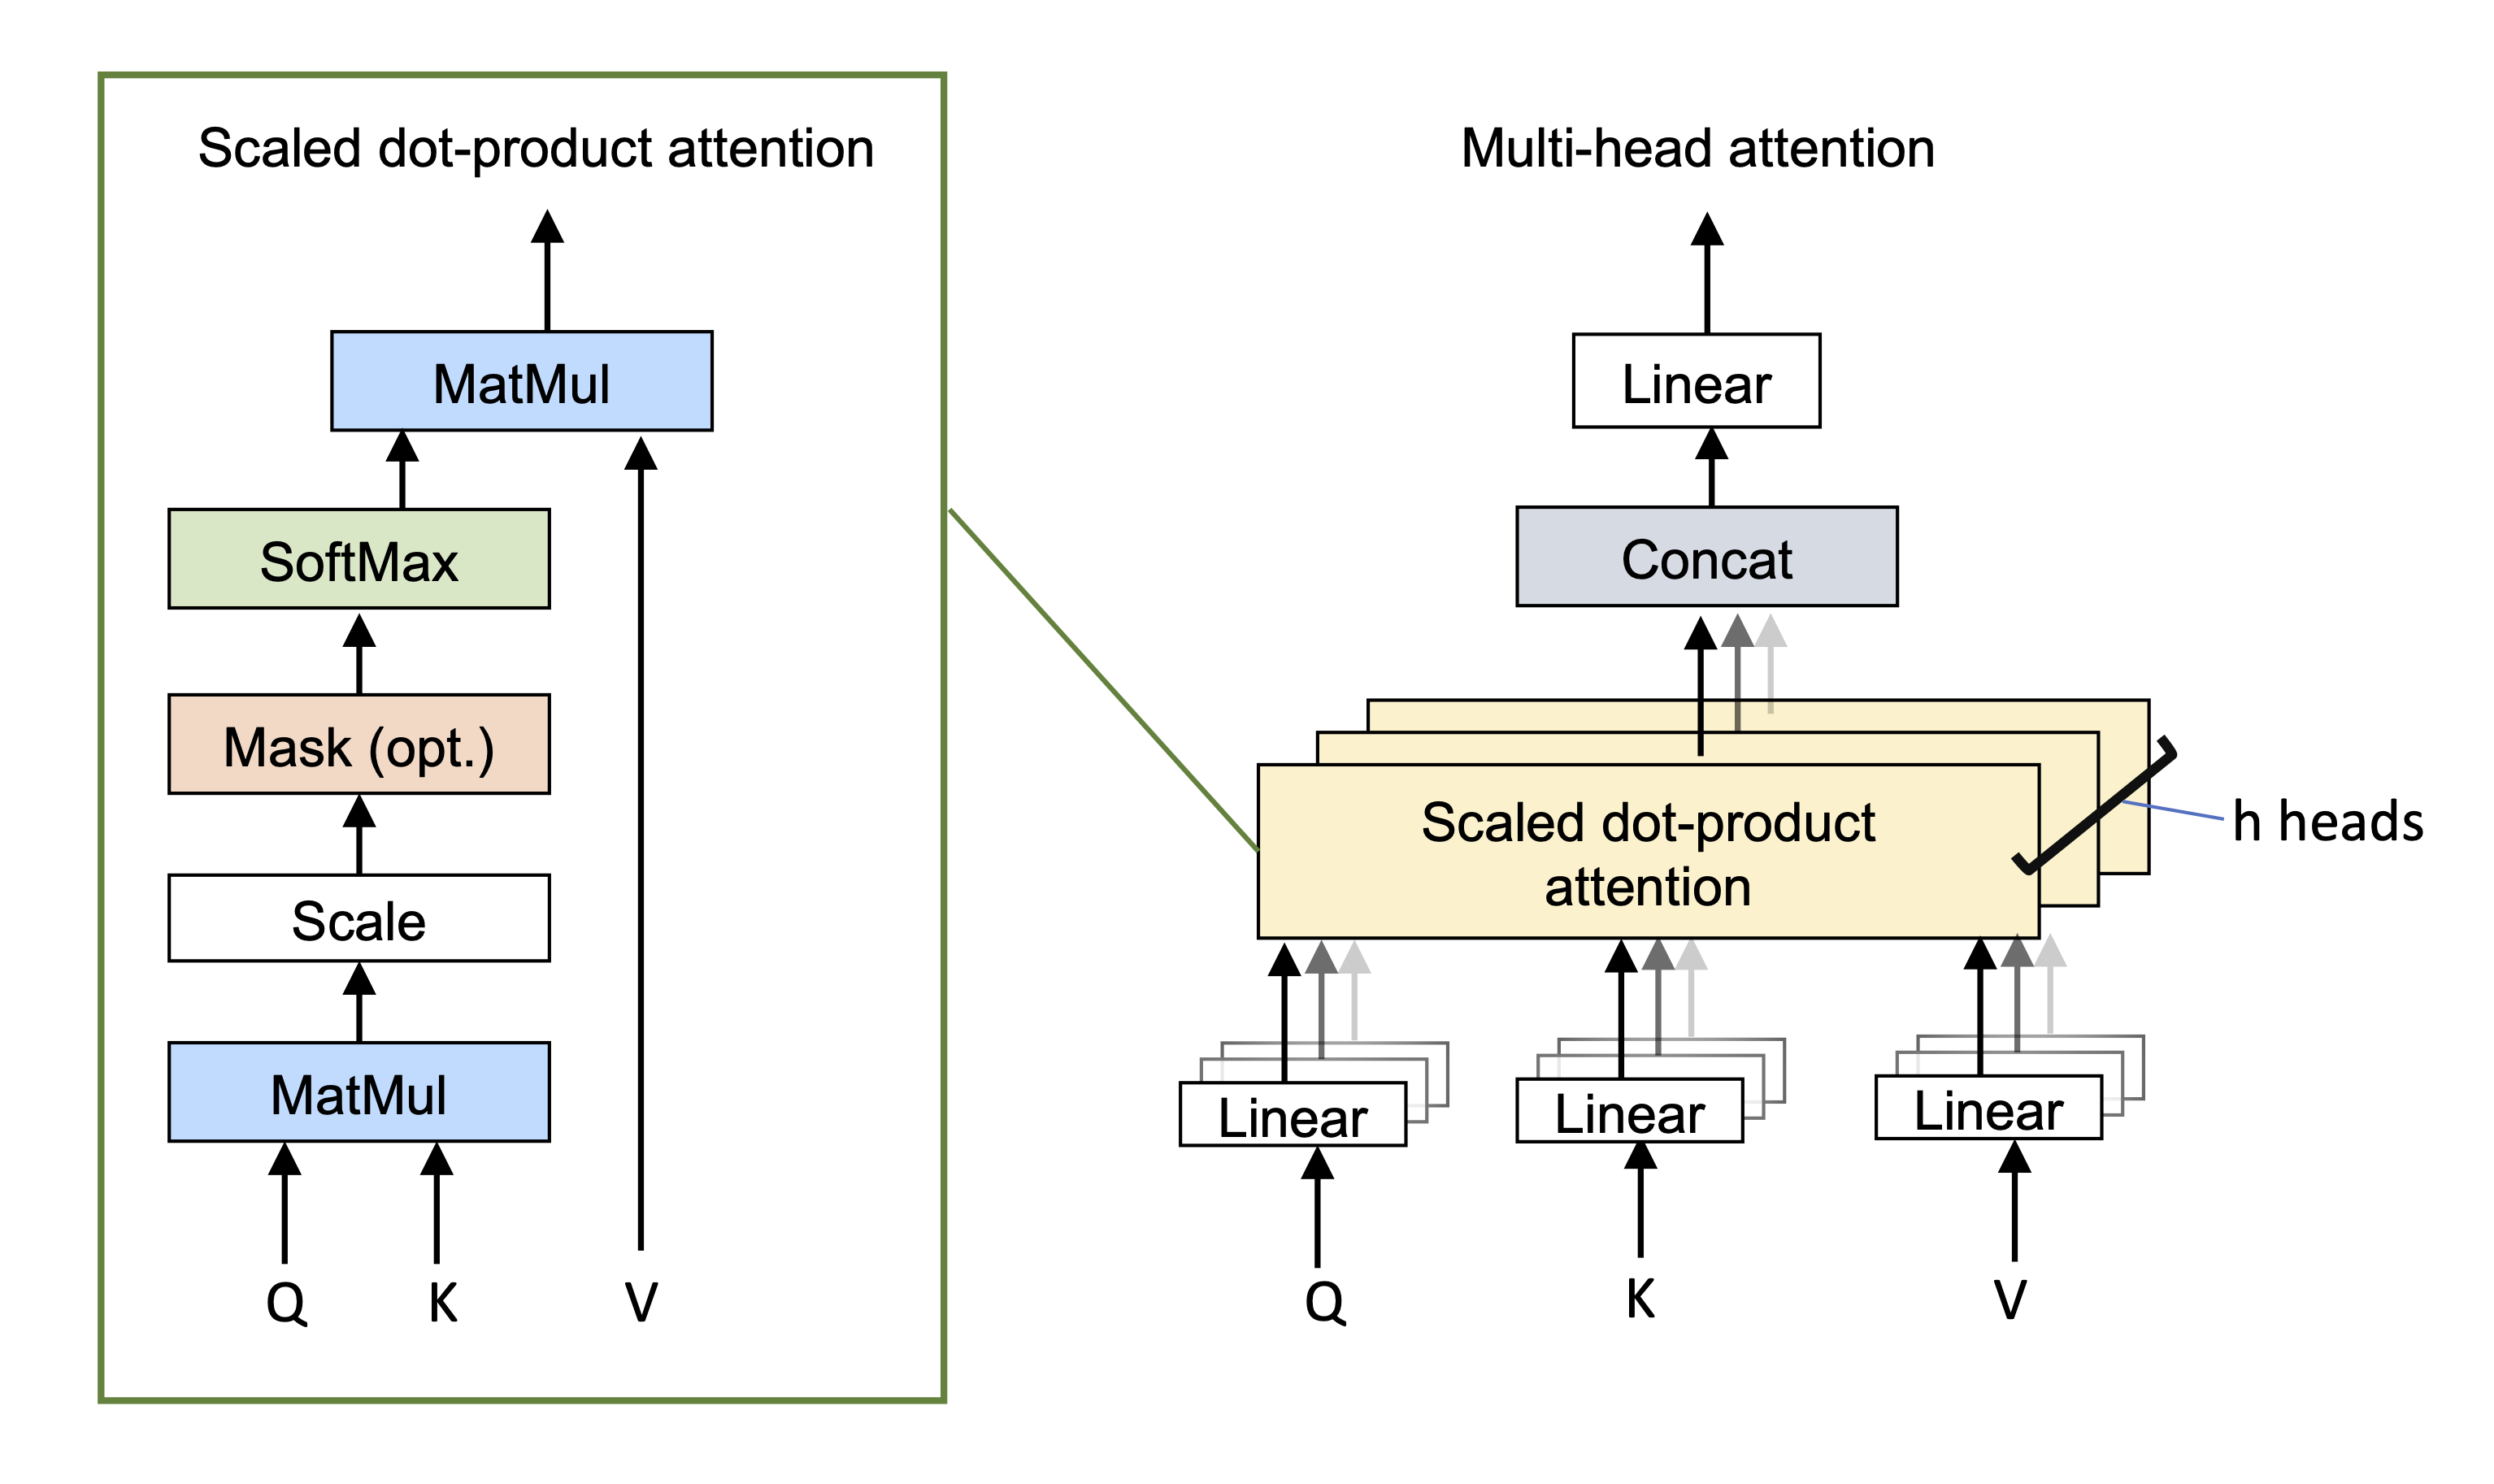

In [39]:
Image(filename='figures/16_07.png', width=700)

In [40]:
linear = torch.nn.Linear(8*16, 16)
context_vector_2 = linear(multihead_z_2.flatten())
context_vector_2.shape

torch.Size([16])

### Learning a language model: decoder and masked multi-head attention

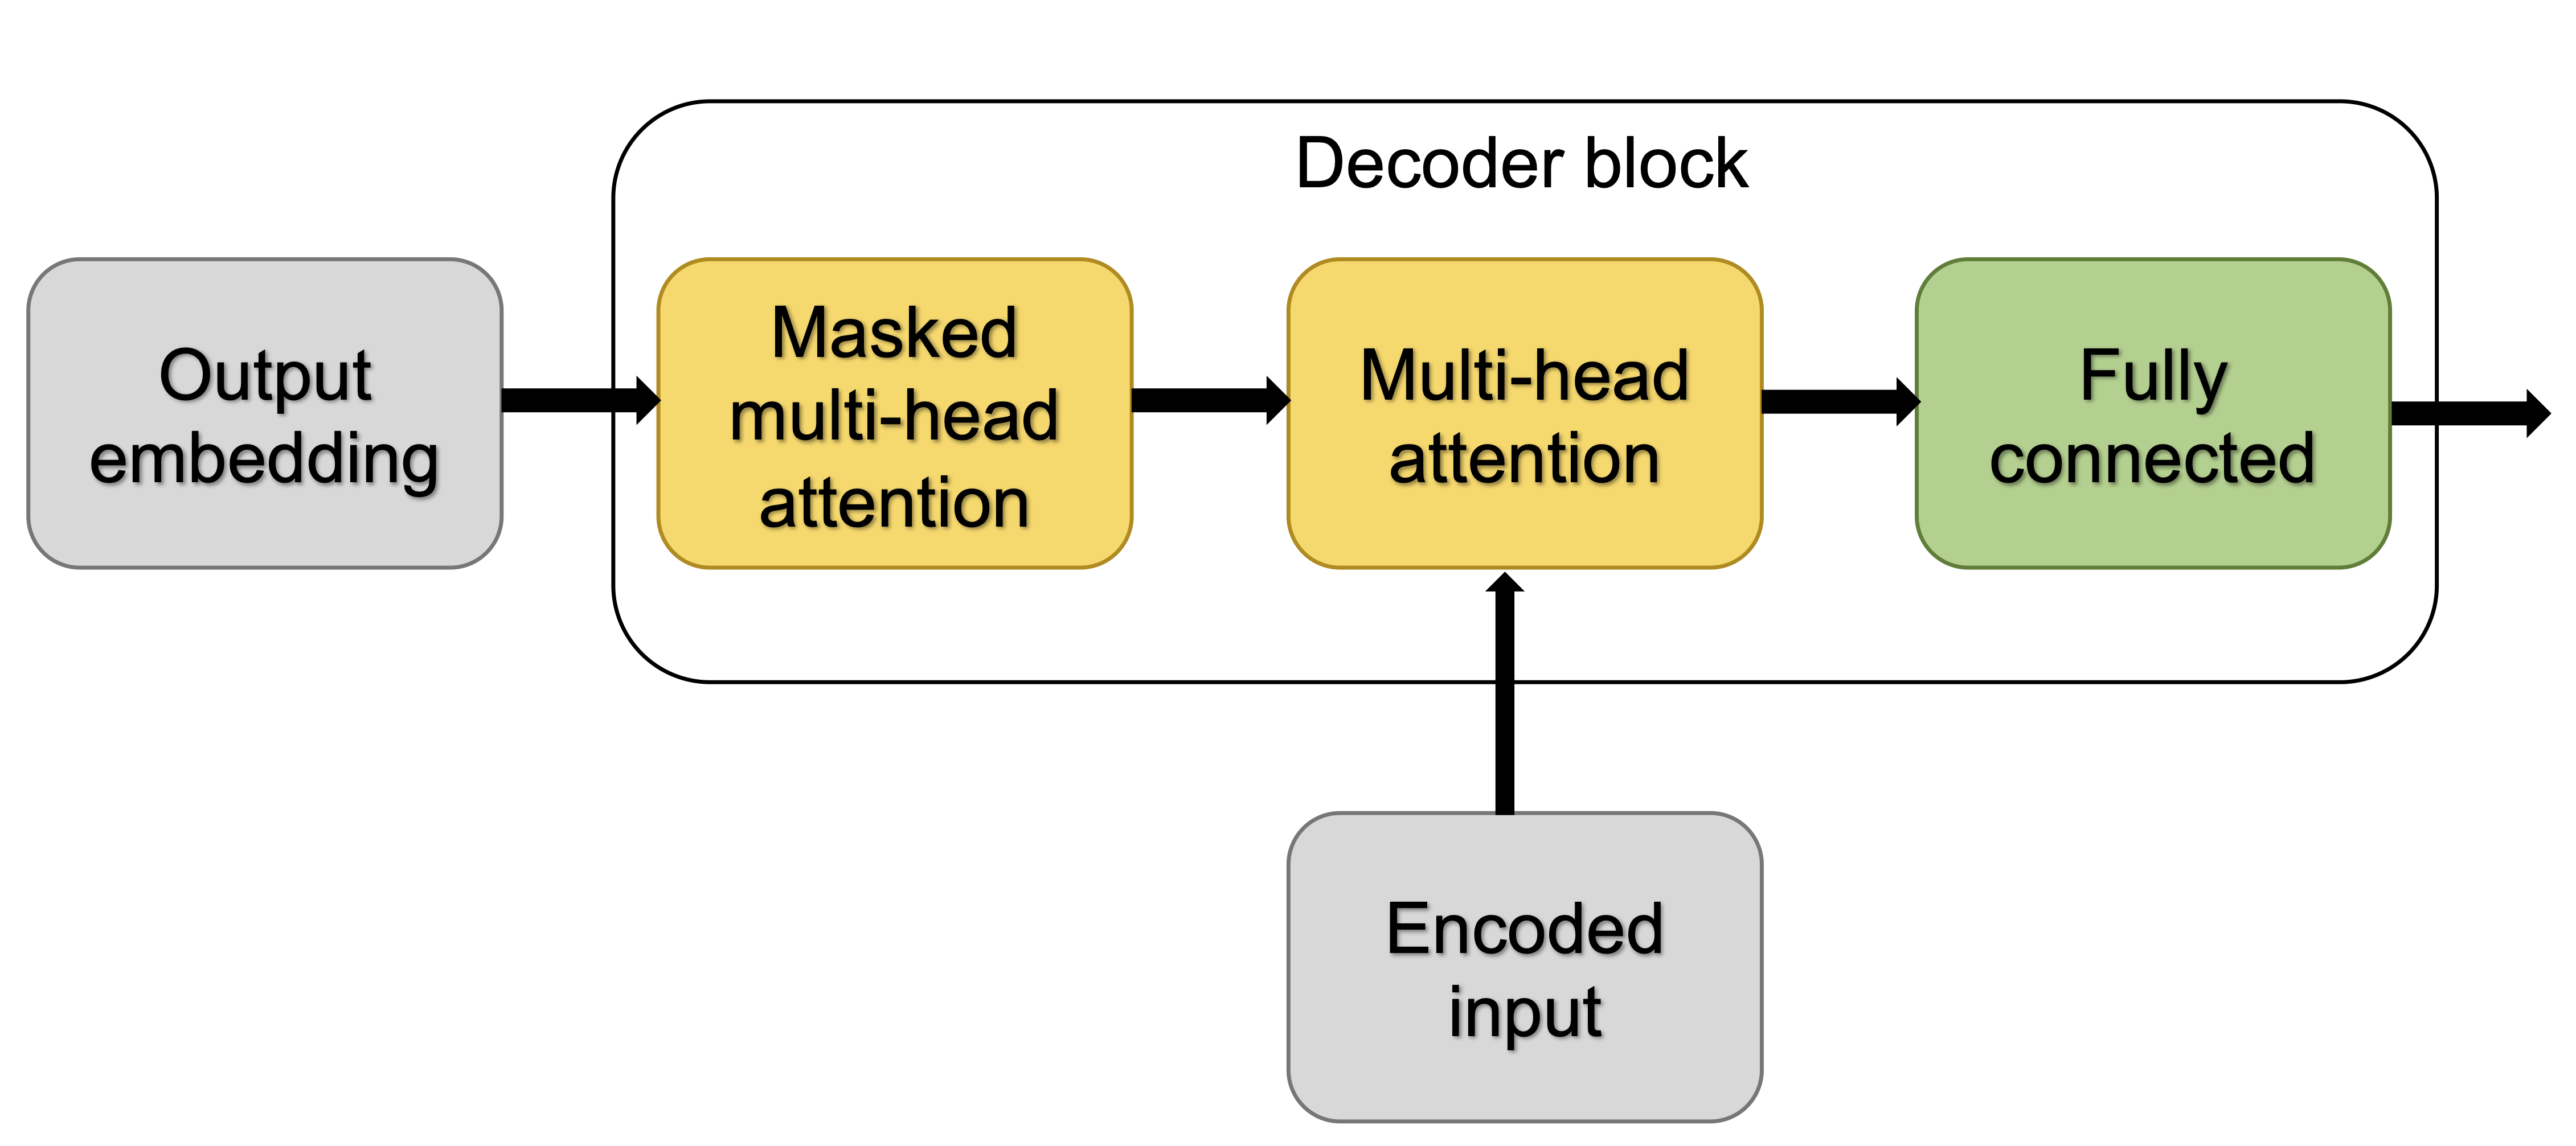

In [41]:
Image(filename='figures/16_08.png', width=600)

### Implementation details: positional encodings and layer normalization

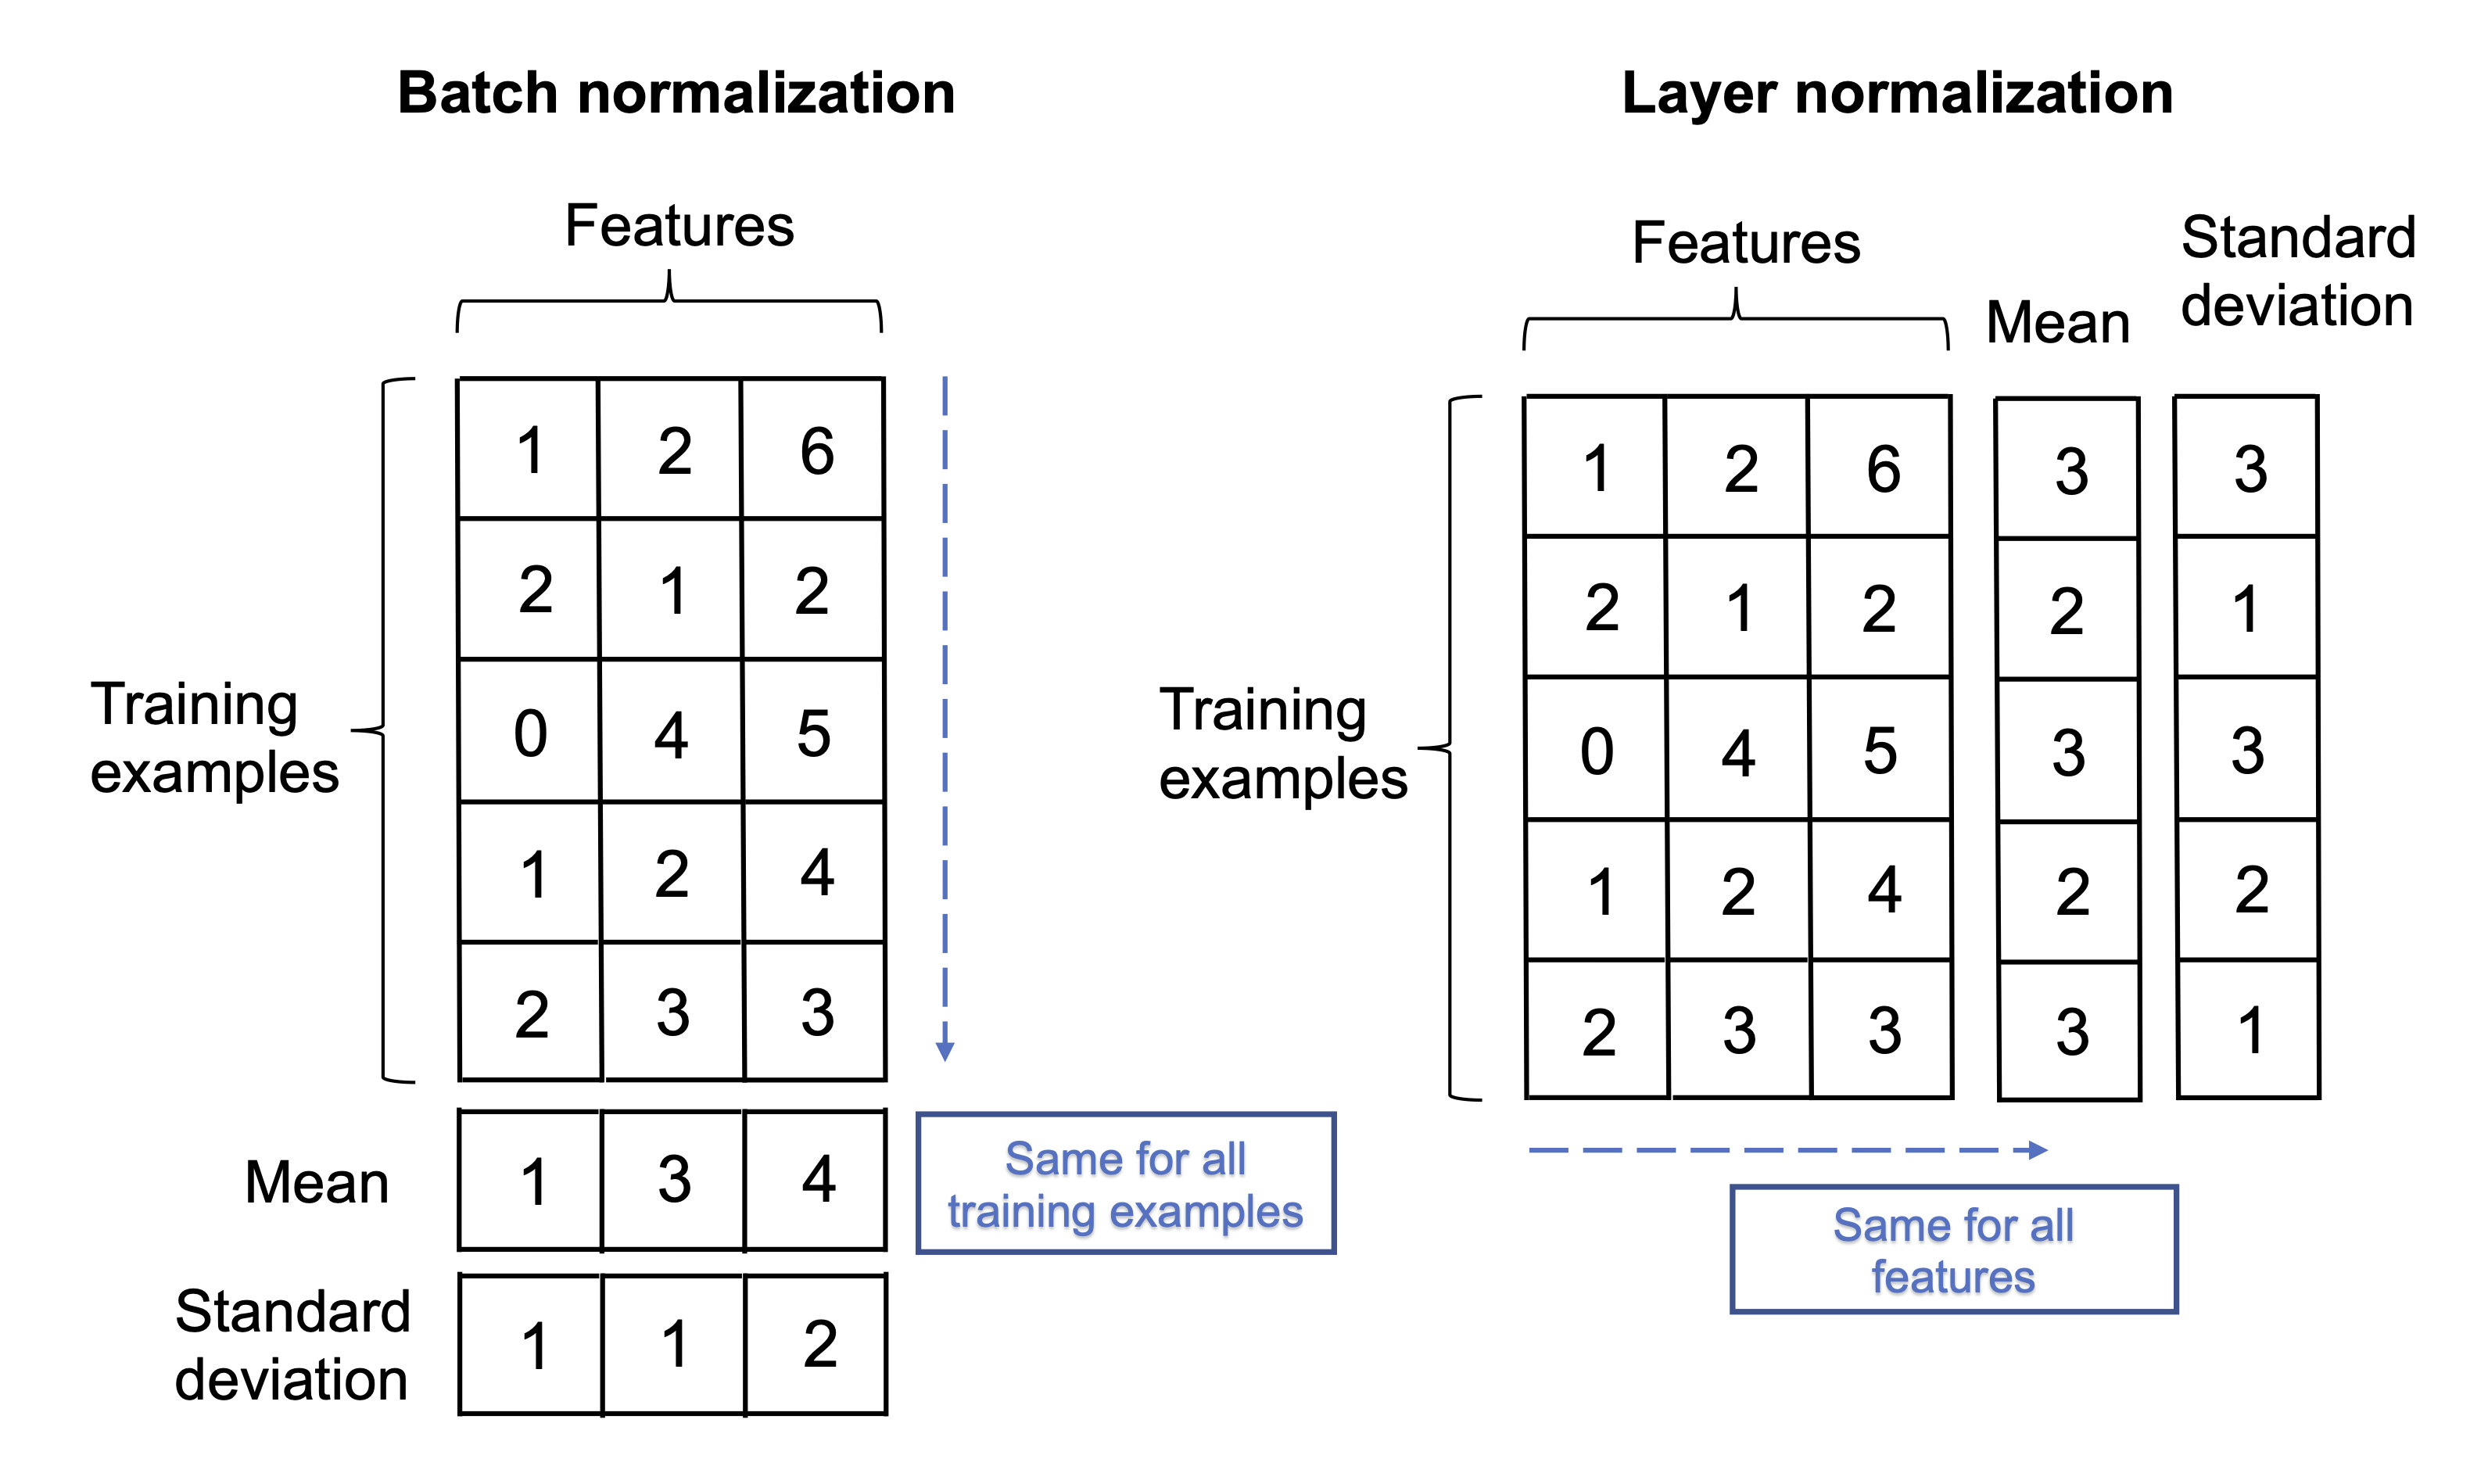

In [42]:
Image(filename='figures/16_09.png', width=600)

---

Readers may ignore the next cell.

In [4]:
! python ../.convert_notebook_to_script.py --input ch16-part1-self-attention.ipynb --output ch16-part1-self-attention.py

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook ch16-part1-self-attention.ipynb to script
[NbConvertApp] Writing 8484 bytes to ch16-part1-self-attention.py
